# RAPIDS & Scanpy Single-Cell RNA Workflow

This notebook demonstrates an end-to-end single-cell RNA workflow that begins with preprocessing a `(n_gene, n_cell)` count matrix and results in a visualization of the clustered cells for further analysis. 

In [1]:
# Import requirements
import numpy as np
import scanpy as sc
import sys
import os

import cupy as cp

In [2]:
# Please note the csv file in in_file has been modified with the addition of `gene_name` to the very beginning of the csv index.
in_file = "/home/cjnolet/covid_omics_local/Counts_lung_cells.csv"
out_dir = "."

In [3]:
import cudf
import anndata

import time
start = time.time()

## Preprocessing Stage 1
### (load counts -> filter -> normalize)

In [4]:
%%time
# Load data
adata = cudf.read_csv(in_file)

CPU times: user 3.84 s, sys: 2.15 s, total: 6 s
Wall time: 5.97 s


In [5]:
adata.columns

Index(['gene_name', 'X101CV0ng_AAACCTGAGGTTCCTA.1',
       'X101CV0ng_AAACCTGCAAGGCTCC.1', 'X101CV0ng_AAACCTGCACGAAATA.1',
       'X101CV0ng_AAACCTGCAGCTATTG.1', 'X101CV0ng_AAACCTGGTGATGCCC.1',
       'X101CV0ng_AAACCTGTCATCATTC.1', 'X101CV0ng_AAACCTGTCCCAGGTG.1',
       'X101CV0ng_AAACGGGAGCTGATAA.1', 'X101CV0ng_AAACGGGCACATTTCT.1',
       ...
       'ZM3KACng_TTTGGTTGTGGGTCAA.1', 'ZM3KACng_TTTGGTTGTTTAGGAA.1',
       'ZM3KACng_TTTGGTTTCCGAATGT.1', 'ZM3KACng_TTTGGTTTCTTGCCGT.1',
       'ZM3KACng_TTTGTCAAGACTCGGA.1', 'ZM3KACng_TTTGTCACAAATACAG.1',
       'ZM3KACng_TTTGTCACAGAGTGTG.1', 'ZM3KACng_TTTGTCACAGTTTACG.1',
       'ZM3KACng_TTTGTCACATCCGCGA.1', 'ZM3KACng_TTTGTCACATGGATGG.1'],
      dtype='object', length=39779)

In [6]:
adata['gene_name'].unique()

0                None
1             5S-rRNA
2                 7SK
3               7SK.1
4               7SK.2
             ...     
32733     hsa-mir-335
32734     hsa-mir-490
32735    hsa-mir-7515
32736    hsa-mir-8072
32737          snoU13
Name: gene_name, Length: 32738, dtype: object

In [7]:
adata.shape

(32738, 39779)

In [8]:
%%time
mito_genes = adata["gene_name"].str.startswith("MT-")
adata = adata.set_index("gene_name")

CPU times: user 330 ms, sys: 7.32 ms, total: 337 ms
Wall time: 337 ms


In [9]:
%%time
gpu_matrix = adata.as_gpu_matrix()

CPU times: user 2.56 s, sys: 157 ms, total: 2.72 s
Wall time: 2.72 s


In [10]:
%%time
import cupy as cp
gpu_array = cp.asarray(gpu_matrix, dtype=cp.float32)

CPU times: user 4.33 ms, sys: 2.2 ms, total: 6.53 ms
Wall time: 5.58 ms


In [11]:
%%time
# Move count matrix to sparse form to ease computational burden.
# Transpose to `(n_cells, n_genes)` in sparse form since it has less computational demands
sparse_gpu_array = cp.sparse.csr_matrix(gpu_array, dtype=cp.float32).T

CPU times: user 503 ms, sys: 337 ms, total: 840 ms
Wall time: 850 ms


In [12]:
sparse_gpu_array.shape

(39778, 32738)

In [13]:
del adata
del gpu_matrix

In [14]:
%%time
# Filter cells w/ 200 <= n_genes <= 6000
# Copying to host (scipy.sparse.csr_matrix) just for filtering. 
# Ref: https://github.com/cupy/cupy/issues/2360
col_sums = sparse_gpu_array.sum(axis=1)
query = ((200 <= col_sums) & (col_sums <= 6000)).ravel()
filtered_cells = sparse_gpu_array.get()[query.get()]

CPU times: user 1.68 s, sys: 1.36 s, total: 3.04 s
Wall time: 3.04 s


In [15]:
%%time
## Filter cells with >15% MT reads
n_counts = filtered_cells.sum(axis=1)
percent_mito = (filtered_cells[:,mito_genes.to_array()].sum(axis=1) / n_counts).ravel()
filtered_cells = filtered_cells[np.asarray(percent_mito < 0.15).ravel(),:]

CPU times: user 394 ms, sys: 129 ms, total: 523 ms
Wall time: 522 ms


In [16]:
%%time
## Remove zero columns
# Copying dense onto GPU for normalization
thr = np.asarray(filtered_cells.sum(axis=0) > 0).ravel()
filtered_cells = filtered_cells[:,thr]
# filtered_cells = cp.array(filtered_cells.todense())

CPU times: user 61.6 ms, sys: 114 ms, total: 176 ms
Wall time: 176 ms


In [17]:
filtered_cells

<34808x28192 sparse matrix of type '<class 'numpy.float32'>'
	with 58229152 stored elements in Compressed Sparse Column format>

In [18]:
%%time
import scipy
## Normalize to sum to 1e4 and perform log norm
target_sum = 1e4
sums = np.array(target_sum / filtered_cells.sum(axis=1)).ravel()

normalized = filtered_cells.multiply(sums[:, np.newaxis]) # Done on host for now
normalized = cp.sparse.csr_matrix(normalized)

CPU times: user 1.77 s, sys: 655 ms, total: 2.43 s
Wall time: 2.43 s


In [19]:
%%time
normalized = normalized.log1p()

CPU times: user 233 µs, sys: 4.13 ms, total: 4.36 ms
Wall time: 3.58 ms


In [20]:
normalized.shape

(34808, 28192)

## Preprocess Stage 2
### (regress -> scale -> PCA) 

In [21]:
%%time
import anndata
adata = anndata.AnnData(normalized.get())

CPU times: user 107 ms, sys: 103 ms, total: 210 ms
Wall time: 209 ms


In [22]:
%%time

min_disp = 0.5

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=min_disp)
n_genes = sum(adata.var.highly_variable)
adata = adata[:, adata.var.highly_variable]

CPU times: user 2.64 s, sys: 128 ms, total: 2.76 s
Wall time: 2.76 s


In [23]:
adata.X.shape

(34808, 3397)

In [24]:
# scanpy uses a Gaussian GLM w/ identity link, which is equivalent to Linear Regression w/  OLS.

In [25]:
n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

In [26]:
regressors = cp.ones((n_counts.shape[0]*3)).reshape((n_counts.shape[0], 3), order="F")

In [27]:
regressors[:, 1] = n_counts
regressors[:, 2] = percent_mito

In [28]:
df_regressors = cudf.DataFrame.from_gpu_matrix(regressors)

In [29]:
# For each gene, we want to subtract the predicted values from the original values to
# regress out effects of total counts per cell and the percentage expressed of mitochondrial genes 

In [30]:
from cuml.linear_model import LinearRegression

# NOTE: The tens of thousands of little regressions required in this step 
# pose a singificant bottleneck to this workflow.

def _regress_out_chunk(data_chunk, regressors):
    """
    Performs a data_cunk.shape[1] number of local linear regressions,
    replacing the data in the original chunk w/ the regressed result. 
    """
    
    output = []
    
    for col in range(data_chunk.shape[1]):
        y = data_chunk[:,col]
        X = regressors
        lr = LinearRegression(fit_intercept=False)
        lr.fit(X, y, convert_dtype=True)
        mu = lr.predict(X)
        
        data_chunk[:, col] = y - mu

    return data_chunk

In [31]:
%%time
normalized = cp.array(adata.X.todense(), order="F")

CPU times: user 893 ms, sys: 437 ms, total: 1.33 s
Wall time: 1.33 s


In [32]:
normalized.shape

(34808, 3397)

In [33]:
%%time
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

import dask.array as da

cluster = LocalCUDACluster()
client = Client(cluster)

bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


CPU times: user 405 ms, sys: 275 ms, total: 681 ms
Wall time: 1.96 s


In [34]:
client

Client Scheduler: tcp://127.0.0.1:44407 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 50.39 GB


In [35]:
%%time
da_normalized = da.from_array(normalized, chunks=(-1, 1000), asarray=False)
da_normalized = da_normalized.map_blocks(lambda cols: _regress_out_chunk(cols, df_regressors), 
                                         dtype=cp.float32)

CPU times: user 49 ms, sys: 6.49 ms, total: 55.5 ms
Wall time: 53.6 ms


In [36]:
%%time
normalized = da_normalized.compute()

CPU times: user 969 ms, sys: 1.49 s, total: 2.46 s
Wall time: 19.2 s


In [37]:
client.close()
cluster.close()

In [38]:
normalized.shape

(34808, 3397)

In [39]:
%%time
# Scale to unit variance and clip values w/ std_dev > 10
mean = normalized.mean(axis=0)
stddev = cp.sqrt(normalized.var(axis=0))
normalized -= mean
normalized /= stddev

CPU times: user 6.2 ms, sys: 4.1 ms, total: 10.3 ms
Wall time: 9.63 ms


In [40]:
%%time
normalized[normalized>10] = 10

CPU times: user 8.02 ms, sys: 8.01 ms, total: 16 ms
Wall time: 16.1 ms


In [41]:
preprocess_time = time.time()

In [42]:
print("Total Preprocess time (includes data load): %s" % (preprocess_time-start))

Total Preprocess time (includes data load): 44.704007387161255


## Cluster & Visualize
### (pca -> cluster -> visualize)

In [43]:
cluster_start = time.time()

In [44]:
%%time
from cuml.decomposition import PCA
normalized = PCA(n_components=50).fit_transform(normalized)

/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


CPU times: user 622 ms, sys: 249 ms, total: 871 ms
Wall time: 889 ms


In [45]:
%%time
import anndata
adata = anndata.AnnData(normalized.get())

CPU times: user 31 ms, sys: 4.99 ms, total: 36 ms
Wall time: 35.5 ms


In [46]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_pcs=50, method='rapids')

CPU times: user 3.57 s, sys: 300 ms, total: 3.87 s
Wall time: 3.81 s


In [47]:
%%time
# UMAP
sc.tl.umap(adata, method='rapids')

AscontiguousArrayTime: 1.3589859008789062e-05
UMAP TIME: 0.6140327453613281
CPU times: user 372 ms, sys: 247 ms, total: 619 ms
Wall time: 626 ms


In [48]:
%%time
# Louvain clustering
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 125 ms, sys: 38.1 ms, total: 163 ms
Wall time: 167 ms


/share/software/miniconda3/envs/rapids-env5/lib/python3.7/site-packages/cugraph/structure/graph.py:334: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


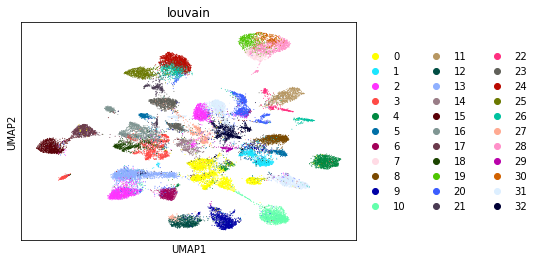

CPU times: user 863 ms, sys: 2.06 s, total: 2.92 s
Wall time: 407 ms


In [49]:
%%time
# Plot
sc.pl.umap(adata, color='louvain')

In [50]:
print("Cluster time: %s" % (time.time() - cluster_start))

Cluster time: 5.967181921005249


In [51]:
print("Full time: %s" % (time.time() - start))

Full time: 50.690184116363525
